

**Introduction: **
The dataset used for this experiment is real and authentic. The dataset is acquired from UCI machine learning repository website [13]. The title of the dataset is ‘Crime and Communities’. It is prepared using real data from socio-economic data from 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crimedata from the 1995 FBI UCR [13]. This dataset contains a total number of 147 attributes and 2216 instances.

From a large list of attributes, only eighteen attributes are chosen for Exploratory Data Analysis. 
The chosen attributes are namely state, HousVacant,PctHouseOccup,PctHousOwnOcc,PctVacantBoarded, PctVacMore6Mos,PctUnemployed,PctEmploy,murdPerPop,rapesPerPop,robbbPerPop,assaultPerPop,burglPerPop, larcPerPop,autoTheftPerPop,arsonsPerPop,nonViolPerPop and ViolentCrimesPerPop.

Regression analysis is limited to the following Predictor and Response variables 
Predictor variables : HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos, PctUnemployed,PctEmploy Response Variables : ViolentCrimesPerPop.

**Questions Answered**

I would like to answer the following questions to start with.

1. Analyze if number of vacant and occupied houses and the period of time the houses were vacant had contributed to any significant change in violent and non-violent crime rates in communities

2. Has there been any correlation between unemployment and crime rate(violent and non-violent) in the communities?

**Data Analysis**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
#from plotly.offline import plot
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
#import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split,KFold,cross_val_score
import re
import json
from pandas.io.json import json_normalize

In [2]:
crimedata = pd.read_csv('/project_data/data_asset/crimedata.csv',sep='\s*,\s*',encoding='latin-1',engine='python',na_values=["?"]) # Read the csv file into dataframe
crimedata = crimedata.rename(columns={'Êcommunityname':'communityName'})
print (crimedata.info())

# fill missing values for the select columns under study with median value of the select columns
cols = ['HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','PctUnemployed','PctEmploy','murdPerPop','rapesPerPop','robbbPerPop','assaultPerPop','ViolentCrimesPerPop','burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop']
crimedata.fillna(crimedata[cols].median(),inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 147 entries, communityName to nonViolPerPop
dtypes: float64(116), int64(29), object(2)
memory usage: 2.5+ MB
None


**Violent and non-Violent crimes by state - Aggregate view**

In [3]:
#group Violent crime and nonViolent crime by state
crimedata_state = crimedata.groupby('state').agg({'ViolentCrimesPerPop':'mean','nonViolPerPop':'mean'})[['ViolentCrimesPerPop','nonViolPerPop']].reset_index()

##Aggregate view of Non-Violent Crimes by State
data1 = dict(type='choropleth',
        colorscale = 'Viridis',
        autocolorscale = False,
        locations = crimedata_state['state'],
        locationmode = 'USA-states',
        z = crimedata_state['nonViolPerPop'].astype(float),
        colorbar = {'title':'non-Violent Crimes(Per-100K-Pop)'}
        )
layout1 = dict(
        title = 'Aggregate view of non-Violent Crimes Per 100K Population',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor='rgb(85,173,240)'),
             )
    
fig1 = go.Figure(data = [data1],layout = layout1)
iplot(fig1,validate=False)

##Aggregate view of Violent Crimes by State
data2 = dict(type='choropleth',
        autocolorscale = False,
        colorscale = "Earth",
        locations = crimedata_state['state'],
        locationmode = 'USA-states',
        z = crimedata_state['ViolentCrimesPerPop'].astype('float'),
        colorbar = {'title':'Violent Crimes(Per-100K-Pop)'}
        )
layout2 = dict(
        title = 'Aggregate view of Violent Crimes Per 100K Population across US',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(85,173,240)'),
             )
    
fig2 = go.Figure(data = [data2],layout = layout2)
iplot(fig2,validate=False)

**Check if there exists multicollinearity between explanatory variables under study**

In [4]:
## Check if there is multicollinearity between any of the explanatory variables under study
cols = ['HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','PctUnemployed','PctEmploy','murdPerPop','rapesPerPop','robbbPerPop','assaultPerPop','ViolentCrimesPerPop','burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop']
crimedata_study = crimedata.filter(cols, axis=1)
corr_crimedata_study = crimedata_study.corr()
iv_corr = corr_crimedata_study.iloc[:-10,:-10]
multicol_limit = 0.3
iv_corr = (iv_corr[abs(iv_corr) > multicol_limit][iv_corr != 1.0]).unstack().to_dict()
iv_multicoll_corr = pd.DataFrame(list(set([(tuple(sorted(key)), iv_corr[key]) for key in iv_corr])), 
        columns=['Independent Variables', 'Correlation Coefficient'])
print (iv_multicoll_corr[iv_multicoll_corr.notnull().all(axis=1)])

                 Independent Variables  Correlation Coefficient
0       (PctHousOwnOcc, PctUnemployed)                -0.394427
8            (PctEmploy, PctHousOccup)                 0.341939
9        (PctEmploy, PctVacantBoarded)                -0.342344
15         (PctEmploy, PctVacMore6Mos)                -0.372459
21   (PctUnemployed, PctVacantBoarded)                 0.549636
24  (PctVacMore6Mos, PctVacantBoarded)                 0.366664
40          (PctEmploy, PctUnemployed)                -0.676430


Per the above output,there exists multicollinearity between PctUnemployed and PctVacantBoarded, PctEmploy and PctUnemployed. These variables, if included in the linear regression model may have significant effect on the model output. However, the current linear model will have these variables for now and final set of explanatory variables that will be included in the model with be done using feature selection as i continue to work on/improve this kernel.

**Communities with highest violent and non-violent crime rate**

In [5]:
# Let's find out the outliers in `ViolentCrimesPerPop` response variable and plot those to find cities with highest crime rate in the US
quartile_1, quartile_3 = np.percentile(crimedata['ViolentCrimesPerPop'], [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
outliers_viol = crimedata.loc[crimedata['ViolentCrimesPerPop']>upper_bound,['communityName','state','ViolentCrimesPerPop']]


## Let's find out the outliers in `nonViolPerPop` response variable and plot those to find cities with highest crime rate in the US
quartile_1, quartile_3 = np.percentile(crimedata['nonViolPerPop'], [25, 75])
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
outliers_nviol = crimedata.loc[crimedata['nonViolPerPop']>upper_bound,['communityName','state','nonViolPerPop']]

## Remove community Name(s) ending with "city". This helps dataframe(s) merging easier to get lat and lon
outliers_viol['communityName'] = outliers_viol['communityName'].map(lambda result : re.sub(r'city','',result))
outliers_nviol['communityName'] = outliers_nviol['communityName'].map(lambda result : re.sub(r'city','',result))

## read citie.json file to get latitude and longitude details of the cities
file = '/project_data/data_asset/cities.json'
with open(file) as city_file:
   dict_city = json.load(city_file)
cities_lat_lon = json_normalize(dict_city)
#print (cities_lat_lon.info())

## merge cities dataframe(with cities_lat_lon dataframe to get lat and lon of the cities) with outliers_viol dataframe 
##and outliers_nviol to plot cities with highest violent/non-vilolent crime rate

violent_crime_cities = pd.merge(outliers_viol,cities_lat_lon,left_on=["communityName","state"],right_on=["city","state"])
violent_crime_cities = violent_crime_cities.drop(["city"],axis=1)
#print (violent_crime_cities)

nonviolent_crime_cities = pd.merge(outliers_nviol,cities_lat_lon,left_on=["communityName","state"],right_on=["city","state"])
nonviolent_crime_cities = nonviolent_crime_cities.drop(["city"],axis=1)
#print (nonviolent_crime_cities)


## Cities with highest  non-violent crime rate
levels = [(0,20),(21,30),(31,40),(41,50),(51,80)]
colors = ['rgb(255,133,27)','rgb(31,120,180)','rgb(178,223,138)','rgb(251,154,153)','rgb(227,26,28)']
plot_data = []
for i in range(len(levels)):
    lim = levels[i]
    nonviolent_crime_cities_sub = nonviolent_crime_cities[lim[0]:lim[1]]
    city_outline = dict(
        type = "scattergeo",
        locationmode = 'USA-states',
        lon = nonviolent_crime_cities_sub['longitude'],
        lat = nonviolent_crime_cities_sub['latitude'],
        text = nonviolent_crime_cities_sub['communityName'] +' '+ nonviolent_crime_cities_sub['nonViolPerPop'].astype(str),
        mode = "markers",
        marker = dict(
        size = nonviolent_crime_cities_sub['nonViolPerPop']/800,
        color = colors[i],
        ),  
    name = '{0} - {1}'.format(lim[0],lim[1])
    )
    layout1 = dict(
        title = 'Cities with highest non-Violent Crime rate',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(85,173,240)'), 
    )
    plot_data.append(city_outline)
    
fig1= dict( data=plot_data, layout=layout1)
iplot( fig1, validate=False)
    
    
## Cities with highest violent crime rate
levels = [(0,30),(31,60),(61,90),(91,120),(121,170)]
colors = ['rgb(175,175,50)','rgb(131,120,180)','rgb(78,230,138)','rgb(251,24,153)','rgb(227,126,28)']
cities = []
for i in range(len(levels)):
    lim = levels[i]
    violent_crime_cities_sub = violent_crime_cities[lim[0]:lim[1]]
    city_outline = dict(
        type = "scattergeo",
        locationmode = 'USA-states',
        lon = violent_crime_cities_sub['longitude'],
        lat = violent_crime_cities_sub['latitude'],
        text = violent_crime_cities_sub['communityName'] +' '+ violent_crime_cities_sub['ViolentCrimesPerPop'].astype(str),
        mode = "markers",
        marker = dict(
        size = violent_crime_cities_sub['ViolentCrimesPerPop']/200,
        color = colors[i]
        ),  
    name = '{0} - {1}'.format(lim[0],lim[1])
    )
    layout2 = dict(
        title = 'Cities with highest Violent Crime rate',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(85,173,240)'),
    ) 
    cities.append(city_outline)
    
fig2= dict( data=cities, layout=layout2)
iplot( fig2, validate=False)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:24: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



**Boxplot - (Violent and non-Violent crime variables)**

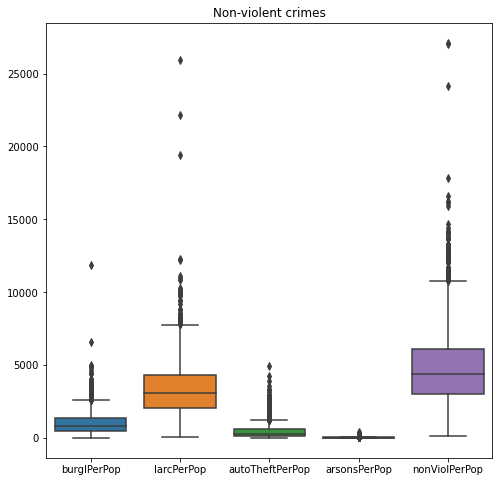

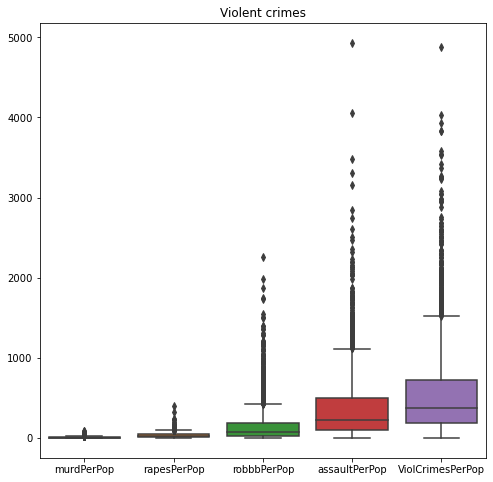

In [6]:
#Exploratory Data Analysis of Response Variables

#Boxplot of non violent crime variables
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
nonViolent = crimedata_study[cols[12:17]]
xticklablesNV = ['burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop']
sns.boxplot(data=nonViolent)
ax.set(title="Non-violent crimes")
ax.set_xticklabels(xticklablesNV)
plt.show()


#Boxplot of Violent crime variables
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
Violent = crimedata_study[cols[7:12]]
xticklablesV = ['murdPerPop','rapesPerPop','robbbPerPop','assaultPerPop','ViolCrimesPerPop']
sns.boxplot(data=Violent)
ax.set(title="Violent crimes")
ax.set_xticklabels(xticklablesV)
plt.show()

**Correlation matrix and Linear Regression model**

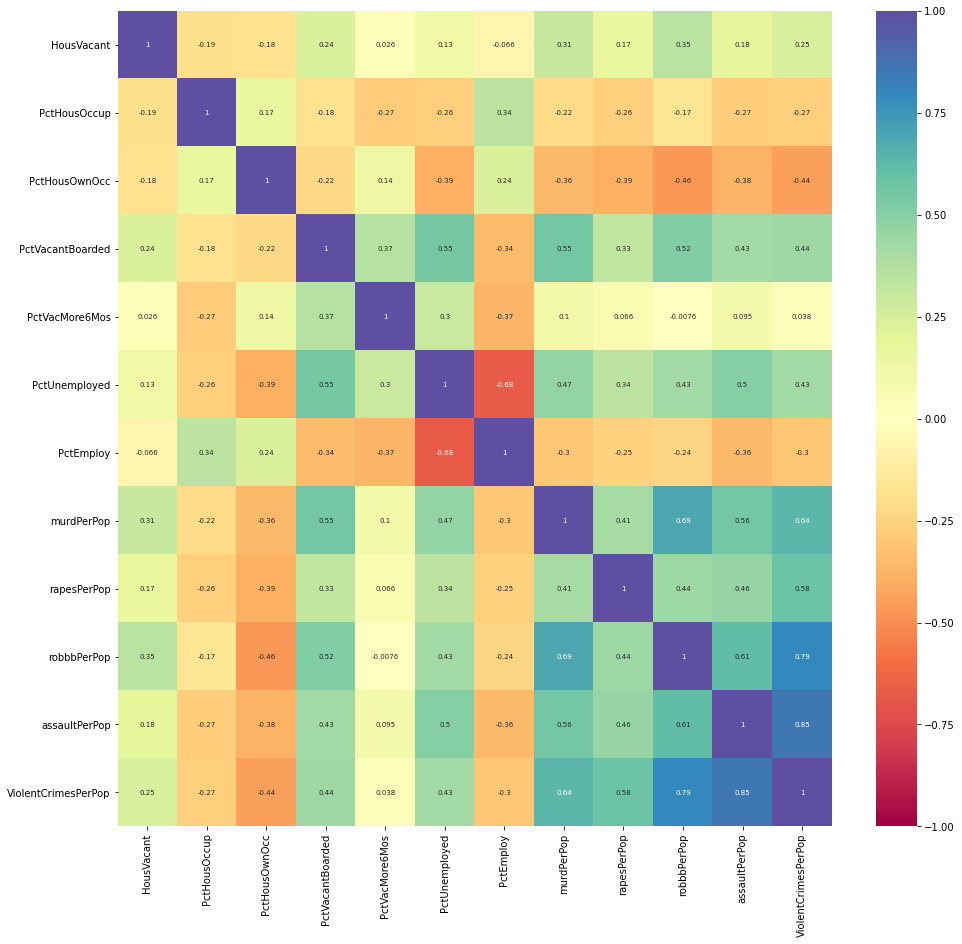

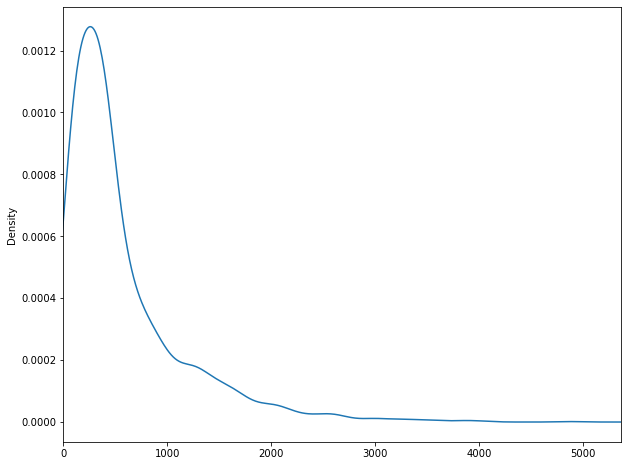

The coeffcients of our model is [ 7.54745466e-03 -1.41786715e+01 -1.10271206e+01  4.95497305e+01
 -5.33677041e+00  1.98332262e+01 -4.35120857e+00]
The intercept for our model is 2768.8156705789784
Linear model Train dataset score is 0.35931157284880066
Linear model Test dataset score is 0.37412307383981225
Cross Validatation Score is [0.36829157 0.2681317  0.26355751 0.45933171 0.31706041 0.47669981
 0.34282423 0.32520228 0.47142926 0.28387437]
Cross Validatation Score mean is 0.3576402835870115
Cross Validatation standard deviation is 0.07924703838521936


In [7]:
### Find out the correlation between explanatory and response under study variables. Indepentdent variables under study is limited
### to Income and employment considering the huge number of variables in the dataset
crimedata_reg = crimedata_study.drop(['burglPerPop','larcPerPop','autoTheftPerPop','arsonsPerPop','nonViolPerPop'],axis=1)
crimedata_reg_corr = crimedata_reg.corr()

### correlation matrix plot
plt.figure(figsize=(16,15))
sns.heatmap(crimedata_reg_corr,annot=True,annot_kws={"size": 7},vmin=-1.0, vmax=1.0,cmap="Spectral")

## "ViolentCrimesPerPop" Density plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax= crimedata_reg['ViolentCrimesPerPop'].plot(kind="kde")
plt.xlim(crimedata_reg['ViolentCrimesPerPop'].min(), crimedata_reg['ViolentCrimesPerPop'].max()*1.1)
plt.show()

## We can see that the density plot is right skewed and further from the boxplot for the response variable "ViolentCrimesPerPop"
## shows the spread of  many outlier data points above the third quartile


## Multiple Linear Regression of variables under study
X = crimedata_reg[['HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','PctUnemployed','PctEmploy']]
y = crimedata_reg['ViolentCrimesPerPop']
## using statsmodel 
##X = sm.add_constant(X)
##mregmodel = sm.OLS(y,X).fit()
##print (mregmodel.summary())
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1)
# fit a model
lm = linear_model.LinearRegression()
mmodel = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
coefficients = mmodel.coef_
print("The coeffcients of our model is {}".format(coefficients))
intercept = mmodel.intercept_
print("The intercept for our model is {}".format(intercept))
print ("Linear model Train dataset score is {}".format(mmodel.score(X_train,y_train)))
print ("Linear model Test dataset score is {}".format(mmodel.score(X_test,y_test)))

##Linear regression using KFold Cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)
results = next(kf.split(X), None)
X_train,y_train = X.iloc[results[0]], y.iloc[results[0]]
X_test,y_test = X.iloc[results[1]],y.iloc[results[1]]

lm = linear_model.LinearRegression()
mm_scores = cross_val_score(lm,X,y,cv=kf)
print ("Cross Validatation Score is {}".format(mm_scores))
print ("Cross Validatation Score mean is {}".format(mm_scores.mean()))
print ("Cross Validatation standard deviation is {}".format(mm_scores.std()))

**Conclusion**

The following explanatory variables HousVacant, PctHousOccup, PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos, PctUnemployed and PctEmploy included in the linear regression analysis explains only 35% variation in the response variable "ViolentCrimesPerPop".

The linear regression model developed will be incomplete without considering the other 120+ explanatory variables available in the dataset. We would also like to see what other variables has had significant effect on violent and non-violent crime rates.